# Explanation of the Script:

1.  **Synthetic Data Generation:**
    * Creates a `pandas.DataFrame` with `num_customers` rows.
    * Includes columns for `age`, `gender`, `region`, various `GA4`-like online metrics (`avg_page_views`, `avg_session_duration`, `num_product_views`, `num_add_to_carts`, `num_online_purchases`, `online_channel`, `has_app_installed`), and simulated `in-store` data (`avg_weekly_spend_instore`, `num_weekly_visits_instore`, `fav_product_category`, `is_near_store`).
    * The `is_member` target variable is generated with a synthetic relationship, where certain features (including being 18-30 and having specific online/in-store behaviors) increase the likelihood of being a member. This simulates the real-world scenario where underlying patterns drive membership.

2.  **Data Preprocessing:**
    * **Categorical Encoding:** `pd.get_dummies` is used for one-hot encoding of categorical features. LightGBM can handle categorical features natively, but one-hot encoding is a common and explicit way to prepare them.
    * **Train-Test Split:** The data is split into training (80%) and testing (20%) sets using `train_test_split`. `stratify=y` is used to ensure that the proportion of members in both the training and testing sets is similar to the overall dataset, which is important for imbalanced datasets.

3.  **LightGBM Model Training:**
    * An `lgb.LGBMClassifier` is initialized. Key parameters like `objective='binary'` (for binary classification) and `metric='auc'` (Area Under the ROC Curve, a robust metric for classification) are set.
    * `n_estimators` (number of trees) and `learning_rate` (shrinkage) are fundamental LightGBM parameters.
    * The model is trained using `lgbm_clf.fit(X_train, y_train)`.

4.  **Model Evaluation:**
    * `predict_proba` is used to get the probability of membership for each customer in the test set.
    * Standard classification metrics are calculated: `roc_auc_score`, `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `confusion_matrix`, and `classification_report`. These metrics provide a comprehensive view of how well the model performs.

5.  **Feature Importance Analysis:**
    * LightGBM models provide `feature_importances_`, which indicate how much each feature contributed to the model's predictions. This is crucial for interpretability and deriving business insights.
    * A bar plot visualizes the top features, showing which aspects of customer behavior or demographics are most predictive of membership.

6.  **Simulating Targeting 18-30 Year Olds:**
    * The script filters the test set to isolate customers aged 18-30.
    * It then uses the trained model to predict membership propensity scores specifically for this age group.
    * A `quantile` is used to define a "high-propensity" threshold (e.g., the top 20% most likely members within the 18-30 age group).
    * Finally, it prints out characteristics and descriptive statistics of these high-propensity 18-30 year olds. This is where you'd derive actionable insights for marketing (e.g., "This segment frequently browses 'Ready Meals' and comes from 'Social' media, so target them with social ads highlighting meal deal member prices").

This script provides a solid foundation for demonstrating your understanding of building and applying a LightGBM model for customer targeting in a data science interview. Remember to explain each section and its purpose, especially how the feature importances and propensity scores translate into actionable business strategies.

***

### --- Step 1. Synthetic Data Generation ---
* Create a synthetic dataset that mimics customer data for membership prediction.
* Features will include online behavior (GA4-like), in-store behavior, and demographics.

In [11]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00


In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Synthetic Data Generation ---
# We'll create a synthetic dataset that mimics customer data for membership prediction.
# Features will include online behavior (GA4-like), in-store behavior, and demographics.

np.random.seed(42) # for reproducibility

num_customers = 100000

# Demographic features
ages = np.random.randint(18, 70, num_customers)
genders = np.random.choice(['Male', 'Female', 'Other'], num_customers, p=[0.48, 0.50, 0.02])
regions = np.random.choice(['London', 'North', 'Midlands', 'South East', 'South West'], num_customers, p=[0.25, 0.20, 0.20, 0.20, 0.15])

# GA4-like online shopping data
avg_page_views = np.random.normal(loc=15, scale=5, size=num_customers).round().astype(int)
avg_session_duration = np.random.normal(loc=300, scale=100, size=num_customers).round().astype(int) # seconds
num_product_views = np.random.normal(loc=10, scale=4, size=num_customers).round().astype(int)
num_add_to_carts = np.random.normal(loc=2, scale=1.5, size=num_customers).round().astype(int)
num_online_purchases = np.random.normal(loc=0.5, scale=1, size=num_customers).round().astype(int)
online_channel = np.random.choice(['Direct', 'Organic Search', 'Paid Search', 'Social', 'Referral'], num_customers, p=[0.2, 0.25, 0.2, 0.15, 0.2])
has_app_installed = np.random.choice([0, 1], num_customers, p=[0.6, 0.4])

# In-store transaction data (from non-members who might become members, or proxy from similar customers)
avg_weekly_spend_instore = np.random.normal(loc=20, scale=10, size=num_customers).round(2)
num_weekly_visits_instore = np.random.normal(loc=1.5, scale=1, size=num_customers).round().astype(int)
fav_product_category = np.random.choice(['Fresh Produce', 'Bakery', 'Ready Meals', 'Frozen', 'Dairy', 'Drinks'], num_customers, p=[0.2, 0.15, 0.2, 0.1, 0.15, 0.2])
is_near_store = np.random.choice([0, 1], num_customers, p=[0.3, 0.7]) # Proxy for geographic proximity

# Ensure non-negative values for counts
avg_page_views[avg_page_views < 0] = 0
avg_session_duration[avg_session_duration < 0] = 0
num_product_views[num_product_views < 0] = 0
num_add_to_carts[num_add_to_carts < 0] = 0
num_online_purchases[num_online_purchases < 0] = 0
num_weekly_visits_instore[num_weekly_visits_instore < 0] = 0
avg_weekly_spend_instore[avg_weekly_spend_instore < 0] = 0.0

# Target variable: is_member (binary: 1 for member, 0 for non-member)
# We'll create a synthetic relationship where certain features increase membership likelihood.
# For example, higher online engagement, more in-store visits, and being in the 18-30 age group might increase propensity to become a member.
base_propensity = 0.1 # Overall low membership rate for non-members
is_member = np.zeros(num_customers)

for i in range(num_customers):
    propensity = base_propensity
    
    # Influence of age: 18-30 year olds might have a slightly higher or lower base propensity
    if 18 <= ages[i] <= 30:
        propensity += 0.08 # Slightly higher propensity for this age group
        if online_channel[i] == 'Social':
            propensity += 0.05 # Social channel users in this age group
    
    # Online engagement influence
    if avg_page_views[i] > 20:
        propensity += 0.05
    if num_add_to_carts[i] > 3:
        propensity += 0.07
    if num_online_purchases[i] > 0:
        propensity += 0.10 # Already purchasing online, higher propensity

    # In-store engagement influence
    if num_weekly_visits_instore[i] > 2:
        propensity += 0.06
    if avg_weekly_spend_instore[i] > 30:
        propensity += 0.08
    if fav_product_category[i] in ['Ready Meals', 'Fresh Produce'] and 18 <= ages[i] <= 30:
        propensity += 0.04 # Specific product categories for young adults

    # Proximity to store
    if is_near_store[i] == 1:
        propensity += 0.03

    # Random noise to make it less deterministic
    propensity = max(0, min(1, propensity + np.random.uniform(-0.05, 0.05)))
    
    if np.random.rand() < propensity:
        is_member[i] = 1

# Create DataFrame
data = pd.DataFrame({
    'age': ages,
    'gender': genders,
    'region': regions,
    'avg_page_views': avg_page_views,
    'avg_session_duration': avg_session_duration,
    'num_product_views': num_product_views,
    'num_add_to_carts': num_add_to_carts,
    'num_online_purchases': num_online_purchases,
    'online_channel': online_channel,
    'has_app_installed': has_app_installed,
    'avg_weekly_spend_instore': avg_weekly_spend_instore,
    'num_weekly_visits_instore': num_weekly_visits_instore,
    'fav_product_category': fav_product_category,
    'is_near_store': is_near_store,
    'is_member': is_member
})

print("--- Synthetic Data Head ---")
print(data.head())
print("\n--- Membership Distribution ---")
print(data['is_member'].value_counts(normalize=True))

--- Synthetic Data Head ---
   age  gender      region  avg_page_views  avg_session_duration  \
0   56  Female       North              23                   289   
1   69  Female  South West              25                   223   
2   46    Male      London              20                   369   
3   32    Male    Midlands              20                   434   
4   60    Male  South East              13                   329   

   num_product_views  num_add_to_carts  num_online_purchases  online_channel  \
0                  3                 4                     1          Direct   
1                  9                 1                     0        Referral   
2                  5                 6                     0  Organic Search   
3                  7                 4                     0          Social   
4                 10                 2                     1          Social   

   has_app_installed  avg_weekly_spend_instore  num_weekly_visits_instore  \
0    

***
### --- Step 2. Data Preprocessing ---
1. Define catergorical and numerical features
2. Use one-hot encoding for categorical features
3. Define independent and dependent variable
4. Split data into training and test sets

In [36]:
# Define categorical and numerical features
categorical_features = ['gender', 'region', 'online_channel', 'fav_product_category']
numerical_features = [col for col in data.columns if col not in categorical_features + ['is_member']]

# LightGBM can handle categorical features natively if specified.
# For simplicity and explicit demonstration, we'll use one-hot encoding here.
# Alternatively, you can pass `categorical_feature` argument to LightGBM.
data_processed = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = data_processed.drop('is_member', axis=1)
y = data_processed['is_member']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (80000, 25)
Testing data shape: (20000, 25)


***
### --- Step 3. Using GridSearchCV to Tune LightGBM ---
1. Define the LightGBM Classifier
2. Define the parameter grid to search
3. Define the scoring metric (roc_auc for classification)
4. Set up GridSearchCV
5. Get parameters and best score

In [39]:
# Define the LightGBM Classifier
# Use a basic setup for the classifier, as GridSearchCV will tune the specific parameters.
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)

# Define the parameter grid to search
# This is a small grid for demonstration. In practice, you might try wider ranges
# or more parameters, but be mindful of computational cost.
param_grid = {
    'n_estimators': [100, 200],         # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1],      # Step size shrinkage
    'num_leaves': [20, 31],            # Max number of leaves in one tree
    'max_depth': [-1, 10],             # Max depth of a tree (-1 means no limit)
    'reg_alpha': [0, 0.1],             # L1 regularization
    'reg_lambda': [0, 0.1]             # L2 regularization
}

# Define the scoring metric. For classification, 'roc_auc' is often preferred
# especially with imbalanced datasets.
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# verbose=2 provides more output during the search
# n_jobs=-1 uses all available CPU cores for parallel processing
grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

print("\n--- Starting GridSearchCV for Hyperparameter Tuning ---")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete.")

# --- 4. Get Best Parameters and Best Score ---
print("\n--- Best Parameters Found by GridSearchCV ---")
print(grid_search.best_params_)

print("\n--- Best ROC AUC Score on Cross-Validation ---")
print(f"Best CV Score: {grid_search.best_score_:.4f}")


--- Starting GridSearchCV for Hyperparameter Tuning ---
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15144, number of negative: 48856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236625 -> initscore=-1.171273
[LightGBM] [Info] Start training from score -1.171273
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=20, reg_alpha=0, reg_lambda=0.1; total time=   1.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15144, number of negative: 48856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18930, number of negative: 61070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236625 -> initscore=-1.171273
[LightGBM] [Info] Start training from score -1.171273
GridSearchCV complete.

--- Best Parameters Found by GridSearchCV ---
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 0}

--- Best ROC AUC Score on Cross-Validation ---
Best CV Score: 0.6300


In [41]:
# --- 5. Use the Best Model for Final Evaluation ---
best_lgbm_model = grid_search.best_estimator_

# Predict probabilities on the test set using the best model
y_pred_proba_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model on the unseen test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

auc_score_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
y_pred_tuned = (y_pred_proba_tuned >= 0.5).astype(int) # Using default 0.5 threshold for classification metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("\n--- Tuned Model Evaluation on Unseen Test Set ---")
print(f"ROC AUC Score (Tuned Model): {auc_score_tuned:.4f}")
print(f"Accuracy (Tuned Model): {accuracy_tuned:.4f}")
print(f"Precision (Tuned Model): {precision_tuned:.4f}")
print(f"Recall (Tuned Model): {recall_tuned:.4f}")
print(f"F1-Score (Tuned Model): {f1_tuned:.4f}")
print("\nConfusion Matrix (Tuned Model):")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))


--- Tuned Model Evaluation on Unseen Test Set ---
ROC AUC Score (Tuned Model): 0.6242
Accuracy (Tuned Model): 0.7636
Precision (Tuned Model): 0.5909
Recall (Tuned Model): 0.0027
F1-Score (Tuned Model): 0.0055

Confusion Matrix (Tuned Model):
[[15259     9]
 [ 4719    13]]

Classification Report (Tuned Model):
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87     15268
         1.0       0.59      0.00      0.01      4732

    accuracy                           0.76     20000
   macro avg       0.68      0.50      0.44     20000
weighted avg       0.72      0.76      0.66     20000




--- Top 10 Feature Importances (Tuned Model) ---
                      feature  importance
7    avg_weekly_spend_instore         366
1              avg_page_views         243
0                         age         221
2        avg_session_duration         215
4            num_add_to_carts         172
8   num_weekly_visits_instore         139
3           num_product_views         135
5        num_online_purchases          95
9               is_near_store          86
19      online_channel_Social          50


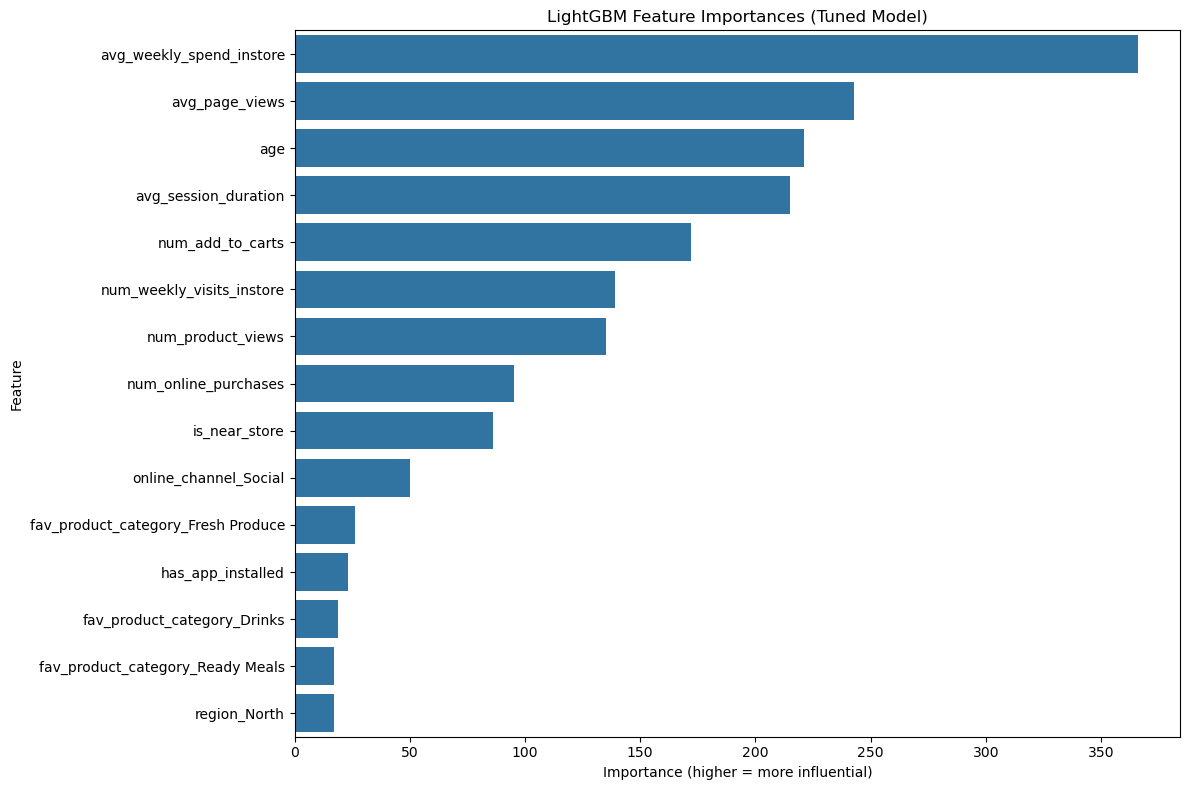

In [43]:
# --- 6. Feature Importance Analysis (from the best model) ---
feature_importances_tuned = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgbm_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n--- Top 10 Feature Importances (Tuned Model) ---")
print(feature_importances_tuned.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_tuned.head(15))
plt.title('LightGBM Feature Importances (Tuned Model)')
plt.xlabel('Importance (higher = more influential)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [47]:
# --- 7. Simulate Targeting 18-30 Year Olds (using the best model) ---
print("\n--- Simulating Targeting 18-30 Year Olds (Tuned Model) ---")

test_data_original = data.loc[X_test.index]
young_adults_test = test_data_original[(test_data_original['age'] >= 18) & (test_data_original['age'] <= 30)]

if not young_adults_test.empty:
    X_young_adults_test = X_test.loc[young_adults_test.index]
    young_adults_propensity_tuned = best_lgbm_model.predict_proba(X_young_adults_test)[:, 1]

    young_adults_test_with_propensity_tuned = young_adults_test.copy()
    young_adults_test_with_propensity_tuned['membership_propensity'] = young_adults_propensity_tuned
    young_adults_test_with_propensity_tuned['is_actual_member'] = y_test.loc[young_adults_test.index]

    print(f"\nTotal 18-30 year olds in test set: {len(young_adults_test_with_propensity_tuned)}")
    print("\nSample of 18-30 year olds with predicted membership propensity (Tuned Model):")
    print(young_adults_test_with_propensity_tuned[['age', 'online_channel', 'avg_weekly_spend_instore', 'membership_propensity', 'is_actual_member']].head(10))

    propensity_threshold_tuned = young_adults_test_with_propensity_tuned['membership_propensity'].quantile(0.80)
    high_propensity_young_adults_tuned = young_adults_test_with_propensity_tuned[young_adults_test_with_propensity_tuned['membership_propensity'] >= propensity_threshold_tuned]

    print(f"\nNumber of 'high-propensity' 18-30 year olds (top 20% by score, Tuned Model): {len(high_propensity_young_adults_tuned)}")
    print(f"Propensity threshold for 'high-propensity' 18-30 year olds (Tuned Model): {propensity_threshold_tuned:.4f}")

    print("\nCharacteristics of a sample of 'high-propensity' 18-30 year olds (Tuned Model):")
    print(high_propensity_young_adults_tuned[['age', 'online_channel', 'avg_weekly_spend_instore', 'num_weekly_visits_instore', 'fav_product_category', 'membership_propensity', 'is_actual_member']].head())

    print("\nDescriptive statistics for 'high-propensity' 18-30 year olds (Tuned Model):")
    print(high_propensity_young_adults_tuned[['avg_page_views', 'avg_session_duration', 'num_add_to_carts', 'avg_weekly_spend_instore', 'num_weekly_visits_instore']].describe())
    print("\nMost common online channels for 'high-propensity' 18-30 year olds (Tuned Model):")
    print(high_propensity_young_adults_tuned['online_channel'].value_counts(normalize=True).head())
    print("\nMost common favorite product categories for 'high-propensity' 18-30 year olds (Tuned Model):")
    print(high_propensity_young_adults_tuned['fav_product_category'].value_counts(normalize=True).head())

    print("\n--- Marketing Actionable Insights (Tuned Model) ---")
    print("Based on this tuned model simulation, Co-op could refine their strategy:")
    print(f"1. Target 18-30 year olds with a membership propensity score of {propensity_threshold_tuned:.2f} or higher.")
    print(f"2. Focus marketing messages for this segment on benefits appealing to their likely interests (e.g., 'Ready Meals' discounts, sustainability, or community initiatives, depending on what the model's features indicate).")
    print(f"3. Prioritise digital channels like '{high_propensity_young_adults_tuned['online_channel'].mode()[0]}' for reaching this segment.")
else:
    print("No 18-30 year olds found in the test set to simulate targeting.")


--- Simulating Targeting 18-30 Year Olds (Tuned Model) ---

Total 18-30 year olds in test set: 4864

Sample of 18-30 year olds with predicted membership propensity (Tuned Model):
       age  online_channel  avg_weekly_spend_instore  membership_propensity  \
11046   25          Social                     12.55               0.398042   
21242   18        Referral                     45.30               0.446696   
85235   26          Social                     21.77               0.416179   
72043   28  Organic Search                      9.94               0.201573   
72864   19  Organic Search                     19.33               0.247302   
25594   22        Referral                     13.07               0.214500   
29365   19  Organic Search                     23.73               0.444536   
25281   29     Paid Search                      7.98               0.325358   
32895   27  Organic Search                     17.66               0.397173   
28025   21  Organic Search    